In [6]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 70
#plt.style.use('dark_background')
import seaborn as sns

from sklearn.decomposition import PCA

In [7]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==1.26.4 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.11.8 pynndescent==0.5.13


In [8]:
adata = sc.datasets.paul15()
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'


The `paul15` dataset is a single-cell RNA sequencing dataset derived from mouse bone marrow, specifically profiling hematopoietic progenitor(not differentiated blood cells which will turn into leukocytes and erythrocytes)cells. Originally published by Paul et al. (Cell, 2015), this dataset captures the transcriptional heterogeneity during early stages of myeloid lineage commitment. It contains expression profiles of over 2700 individual cells and is commonly used to study differentiation trajectories of cell types such as erythrocytes, monocytes, and granulocytes.

This dataset is particularly valuable for analyzing how stem and progenitor cells transition into more committed myeloid lineages. Through unsupervised clustering, dimensionality reduction (e.g., PCA, UMAP), and marker gene analysis, researchers can identify distinct cellular subpopulations, explore lineage bifurcations, and validate known markers or discover novel ones. 


In [9]:
adata.var.head()

""
0610007L01Rik
0610009O20Rik
0610010K14Rik
0910001L09Rik
1100001G20Rik


In [10]:
adata.var_names_make_unique()

In [11]:
adata.obs.head()

,paul15_clusters
W31105,7MEP
W31106,15Mo
W31107,3Ery
W31108,15Mo
W31109,3Ery


In [12]:
adata.obs

,paul15_clusters
W31105,7MEP
W31106,15Mo
W31107,3Ery
W31108,15Mo
W31109,3Ery
...,...
W39164,2Ery
W39165,13Baso
W39166,7MEP
W39167,15Mo


QC

In [13]:
n_counts_array = adata.X.sum(axis=1) # axis=1 to sum over genes, axis=0 to sum over cells
adata.obs['n_counts'] = n_counts_array

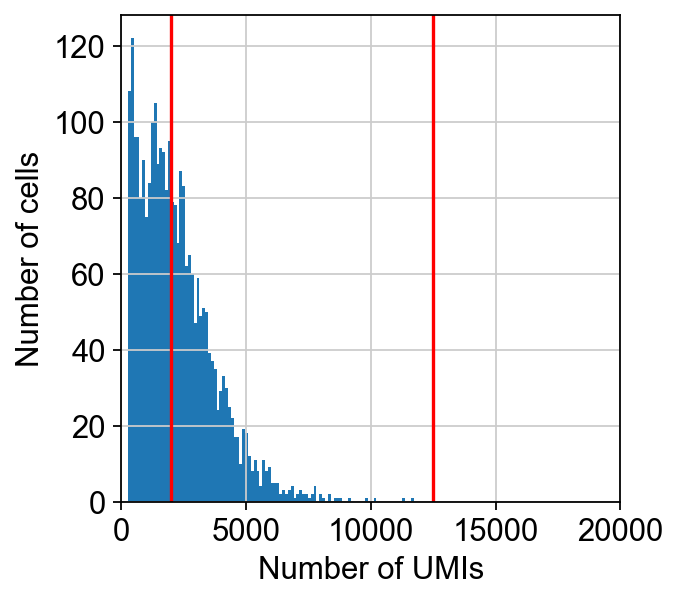

In [14]:
plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Number of UMIs")
plt.ylabel("Number of cells")
plt.axvline(2000, c="r") # choose a lower cutoff for total UMIs
plt.axvline(12500, c="r") # choose a upper cutoff for total UMIs
plt.xlim(0, 20000)
plt.show()

shows how many mRNA molecules (UMIs) were detected in each cell. Most cells have a medium number of UMIs. The red lines might be thresholds to remove cells with too few (likely low quality) or too many (possibly doublets) UMIs.

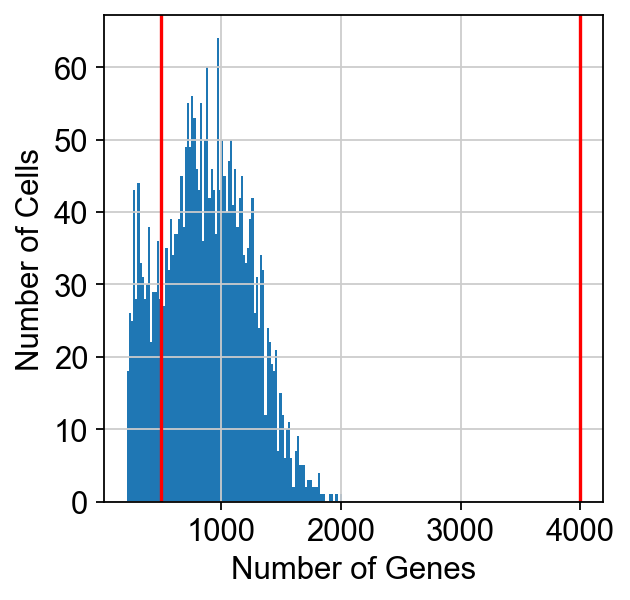

In [15]:
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes

plt.hist(adata.obs['n_genes'], bins=100)
plt.axvline(500, c="r") # choose a lower cutoff for number of detected genes
plt.axvline(4000, c="r") # choose a upper cutoff for number of detected genes
plt.xlabel("Number of Genes")
plt.ylabel("Number of Cells")
plt.show()

shows how many different genes were detected in each cell. Again, most cells express a similar number of genes. The red lines could be thresholds to filter out cells with too few or too many genes.

also these values with the red lines shows us where we should set parameters like min_genes,max_counts etc. .

In [16]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith ("MT-")

# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [101]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20]) 

In [18]:
adata.obs.head()

,paul15_clusters,n_counts,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb
W31105,7MEP,353.0,277,277,5.627621,353.0,5.869297,16.430595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
W31106,15Mo,2556.0,1021,1021,6.929517,2556.0,7.846590,21.361502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
W31107,3Ery,4649.0,1466,1466,7.290975,4649.0,8.444622,13.959991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
W31108,15Mo,4486.0,1415,1415,7.255591,4486.0,8.408939,18.903255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
W31109,3Ery,5205.0,1505,1505,7.317212,5205.0,8.557567,13.429395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


based on the data we get from the upper cell and the adata.obs output we don't needn any integration because paul15 comes from the same batch since there are no information about different batches .

In [19]:
adata.var_names

Index(['0610007L01Rik', '0610009O20Rik', '0610010K14Rik', '0910001L09Rik',
       '1100001G20Rik', '1110002B05Rik', '1110004E09Rik', '1110007A13Rik',
       '1110007C09Rik', '1110013L07Rik',
       ...
       'hnRNP A2/B1', 'mFLJ00022', 'mKIAA0007', 'mKIAA0569', 'mKIAA0621',
       'mKIAA1027', 'mKIAA1575', 'mKIAA1994', 'rp9', 'slc43a2'],
      dtype='object', length=3451)

PLOTTING EXPERIMENTAL METADATA 


normalizing counts per cell


    finished (0:00:00)


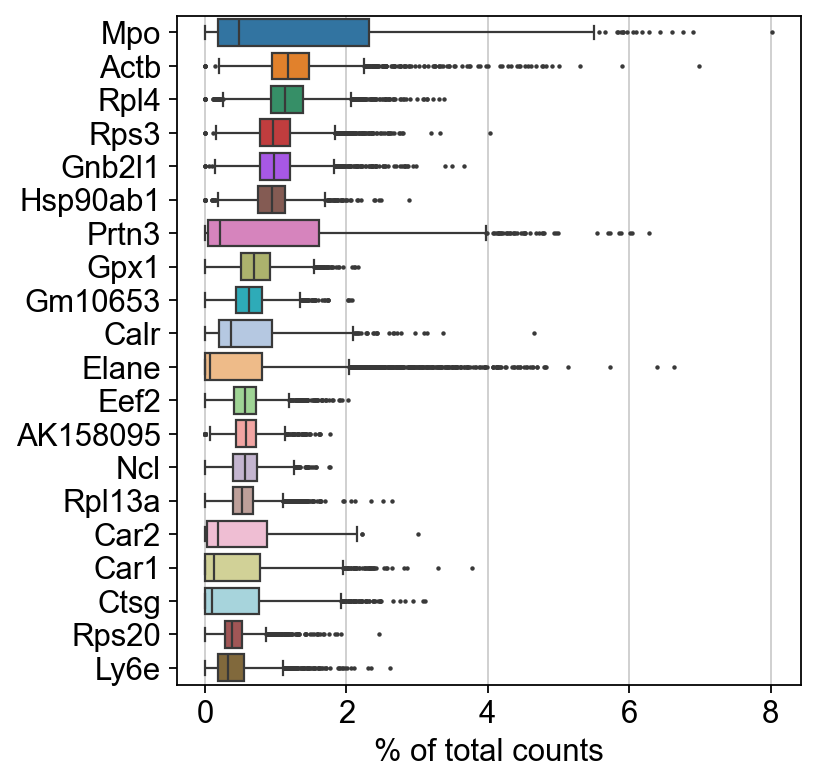

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'iroot', 'pca', 'dendrogram_paul15_clusters'
    obsm: 'X_pca'
    varm: 'PCs'

In [21]:
sc.pl.highest_expr_genes(adata, n_top=20, )
adata #bu bir preprocessing adımı.

X-axis: Shows the percentage of total RNA for each gene.
Boxes: Show the middle 50% of the data for each gene. The line inside is the median (middle value).
Whiskers: Show the spread of most of the data.
Dots: Are outliers (values that are very different from the rest).

for expression levels genes on the right are more abundant
Wide boxes and whiskers mean a gene's expression varies a lot between cells and narrow ones are more consistent.

In [22]:
sc.pp.filter_cells(adata, min_genes=50) # Remove cells that do not have  50 genes per cell
sc.pp.filter_genes(adata, min_cells=1)
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'iroot', 'pca', 'dendrogram_paul15_clusters'
    obsm: 'X_pca'
    varm: 'PCs'

In [23]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# Added columns: 
    # for obs - 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    # for var -  'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'iroot', 'pca', 'dendrogram_paul15_clusters'
    obsm: 'X_pca'
    varm: 'PCs'

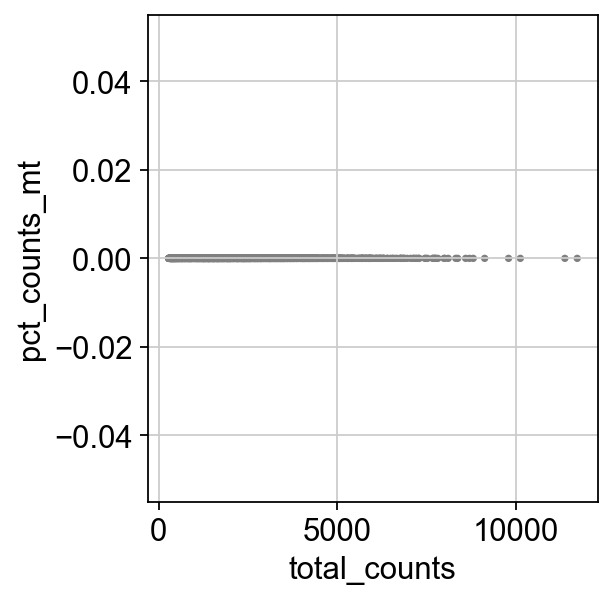

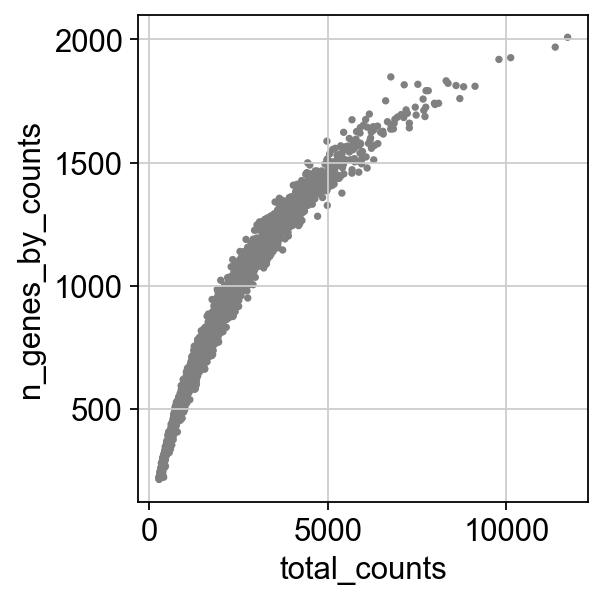

In [24]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

the two meaningless outputs that we get from the code of the 2 upper cell might occur because paul15 had already gone through the preprocessing and some values might be outed.

In [25]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata

View of AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'iroot', 'pca', 'dendrogram_paul15_clusters'
    obsm: 'X_pca'
    varm: 'PCs'

In [26]:
sc.pp.normalize_total(adata, target_sum=1e4)


normalizing counts per cell
    finished (0:00:00)


/opt/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [27]:
sc.pp.log1p(adata)

In [28]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata

extracting highly variable genes


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'iroot', 'pca', 'dendrogram_paul15_clusters', 'log1p', 'hvg'
    obsm: 'X_pca'
    varm: 'PCs'

In [29]:
adata.var[ [ 'highly_variable', 'means', 'dispersions', 'dispersions_norm' ]].head()

,highly_variable,means,dispersions,dispersions_norm
0610007L01Rik,False,1.162190,2.049751,-0.730738
0610009O20Rik,False,0.784609,2.081335,-0.444599
0610010K14Rik,False,2.101715,2.257297,-0.020292
0910001L09Rik,False,1.444433,2.382899,0.259460
1100001G20Rik,True,0.299702,2.580549,0.723910


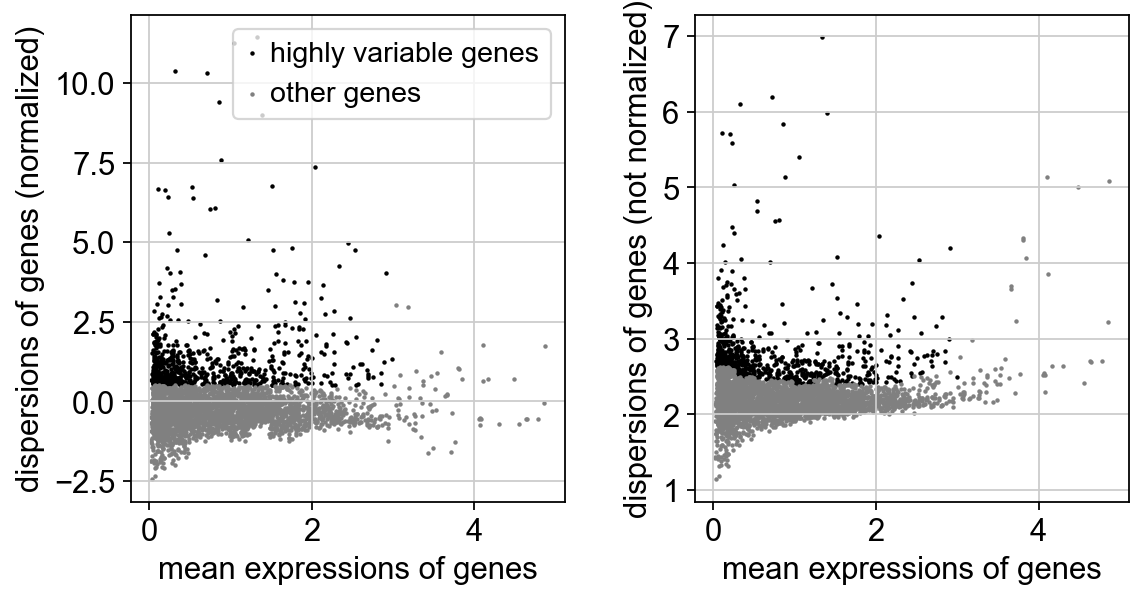

In [30]:
sc.pl.highly_variable_genes(adata)

for the two plots in the upper cell:
x-axis represents the average expression levels of genes
every dot represents a gene

    for the left plot: 
    y-axis represents normalized dispersion of the genes. Normalization is often done to account for differences in mean expression levels of genes. It aims to correct for the fact that genes with higher mean expression may naturally have higher variance.

    for the right plot:
    The y-axis shows the unnormalized (raw) variances (dispersions) of the genes. In this plot, it is clearly seen that genes with higher mean expression levels generally have higher variance.

In [31]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 2730 × 685
    obs: 'paul15_clusters', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'iroot', 'pca', 'dendrogram_paul15_clusters', 'log1p', 'hvg'
    obsm: 'X_pca'
    varm: 'PCs'

PRINCIPAL COMPONENT ANALYSIS

In [32]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


/opt/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [33]:
adata

AnnData object with n_obs × n_vars = 2730 × 685
    obs: 'paul15_clusters', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'iroot', 'pca', 'dendrogram_paul15_clusters', 'log1p', 'hvg'
    obsm: 'X_pca'
    varm: 'PCs'

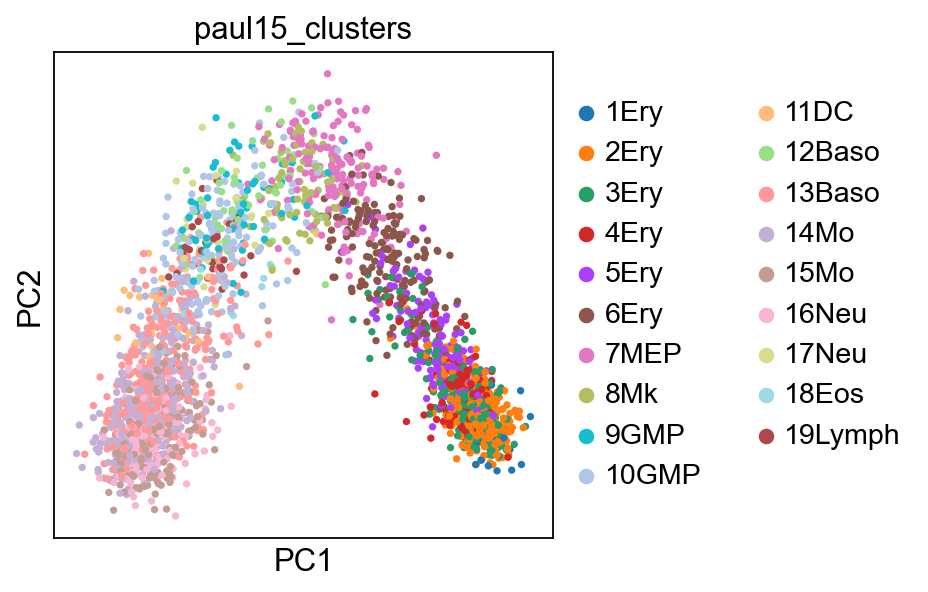

In [34]:
sc.pl.pca(adata, color='paul15_clusters')

cells here are grouped by their gene expression. Different colors represent different cell populations

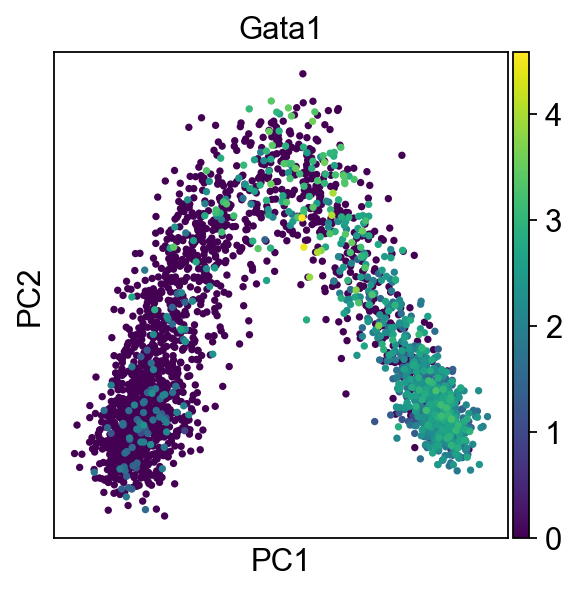

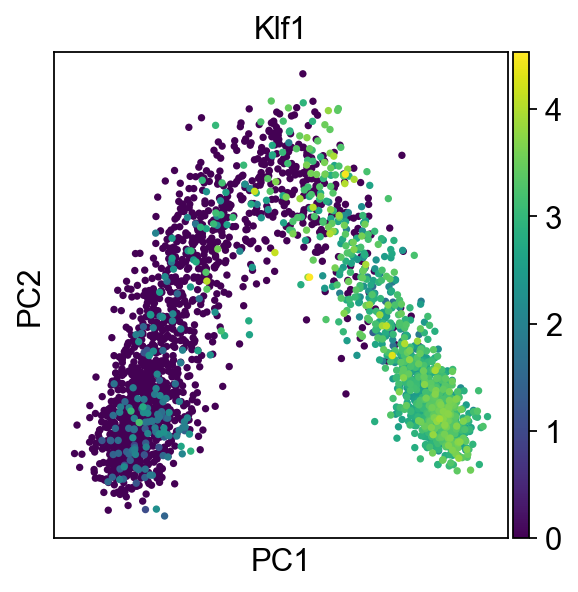

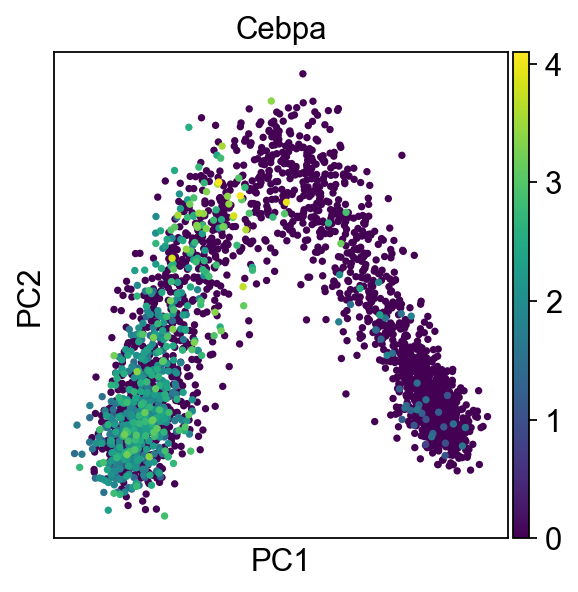

In [103]:
sc.pl.pca(adata, color='Gata1')   # hematopoietik differentiation
sc.pl.pca(adata, color='Klf1')    # Eritroid cell marker
sc.pl.pca(adata, color='Cebpa')   # Myeloid differentiation marker

 expression levels of of the Gata1, Cebpa and Klf1 genes across all cells. The color gradient indicates the expression: darker colors mean lower expression, and lighter (yellow) colors mean higher expression.

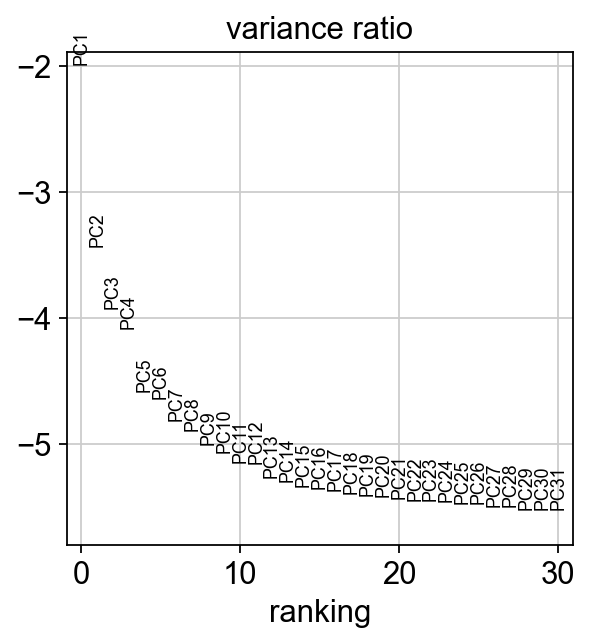

In [36]:
sc.pl.pca_variance_ratio(adata, log=True)

In the upper cell we are looking for the effects of single PC's to the total variance in our data. PC's are considered for the neighborhood relations.

In [37]:
results_file = "paul15_processed.h5ad"
adata.write(results_file)

COMPUTONG THE NEIGHBORHOOD GRAPH

In [38]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15) 

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


EMBEDDING THE NEIGHBORHOOD GRAPH

In [39]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)


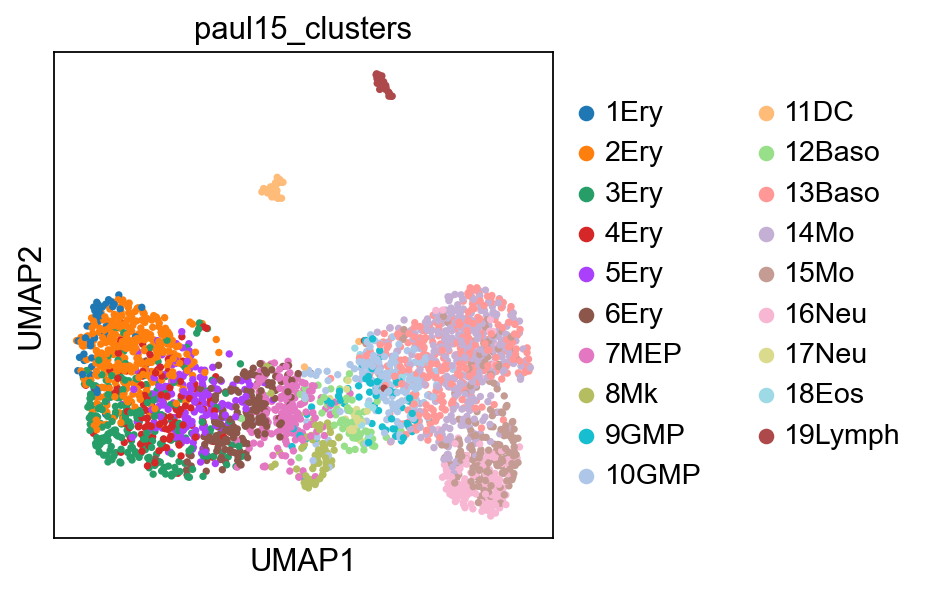

In [94]:
sc.pl.umap(adata , color=['paul15_clusters'])

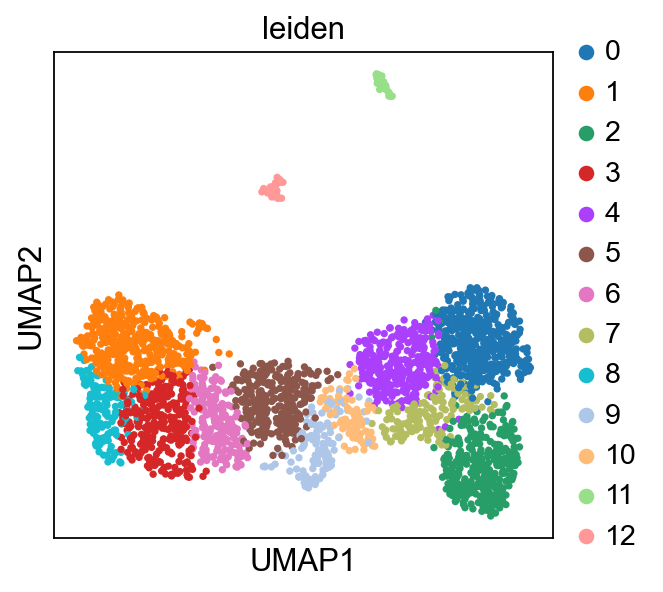

In [93]:
sc.pl.umap(adata , color=['leiden'])

for the two upper cells you can see how leiden clusters and how the data is clustered in paul15.

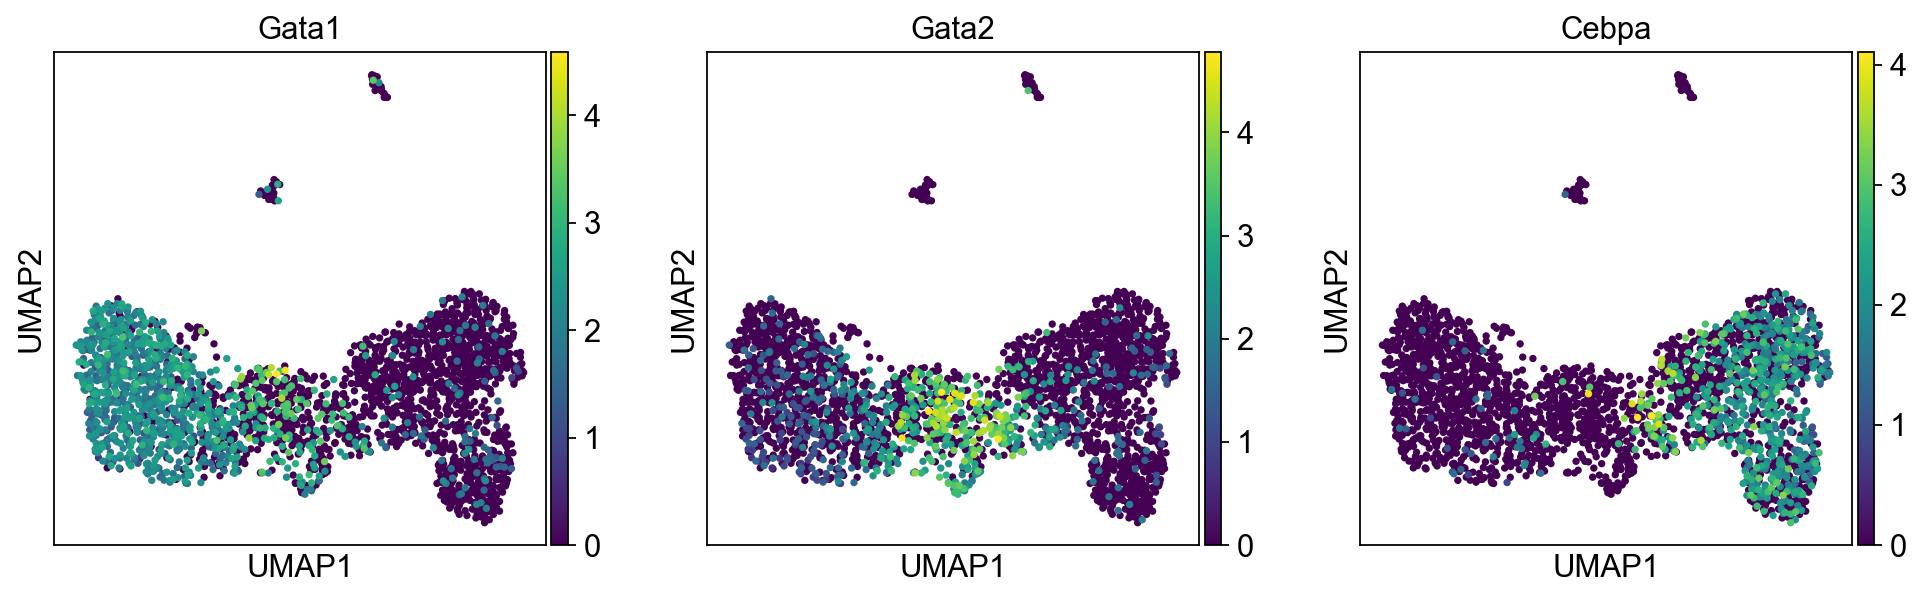

In [53]:
sc.pl.umap(adata, color=['Gata1', 'Gata2', 'Cebpa'])
# Gata1: erithroid, Gata2: stem cells, Elane: neutrophills

The difference between the upper and lower cell is that in the upper cell we used raw data and even thpugh its raw paul15 was a preprocessed data so there are not many differences between the two.

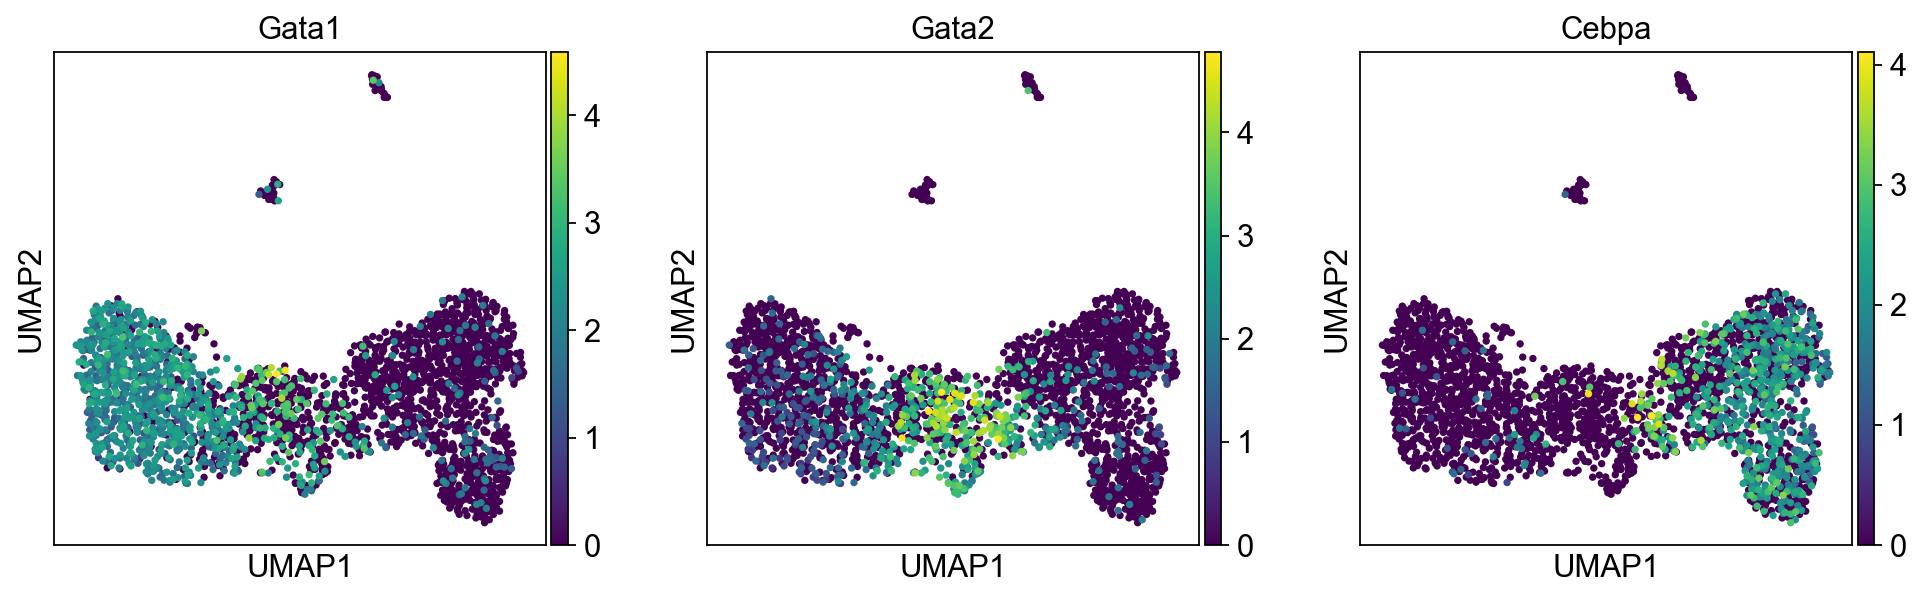

In [54]:
sc.pl.umap(adata, color=['Gata1', 'Gata2', 'Cebpa'], use_raw=False)

CLUSTERING THE NEIGHBORHOOD GRAPH

In [ ]:
!pip install leidenalg

In [43]:
sc.tl.leiden(adata)

running Leiden clustering


/var/folders/k6/mkdj54d14h94_0wl7gptfc980000gn/T/ipykernel_4087/3467744858.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [45]:
adata.write(results_file)

FINDING MARKER GENES

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


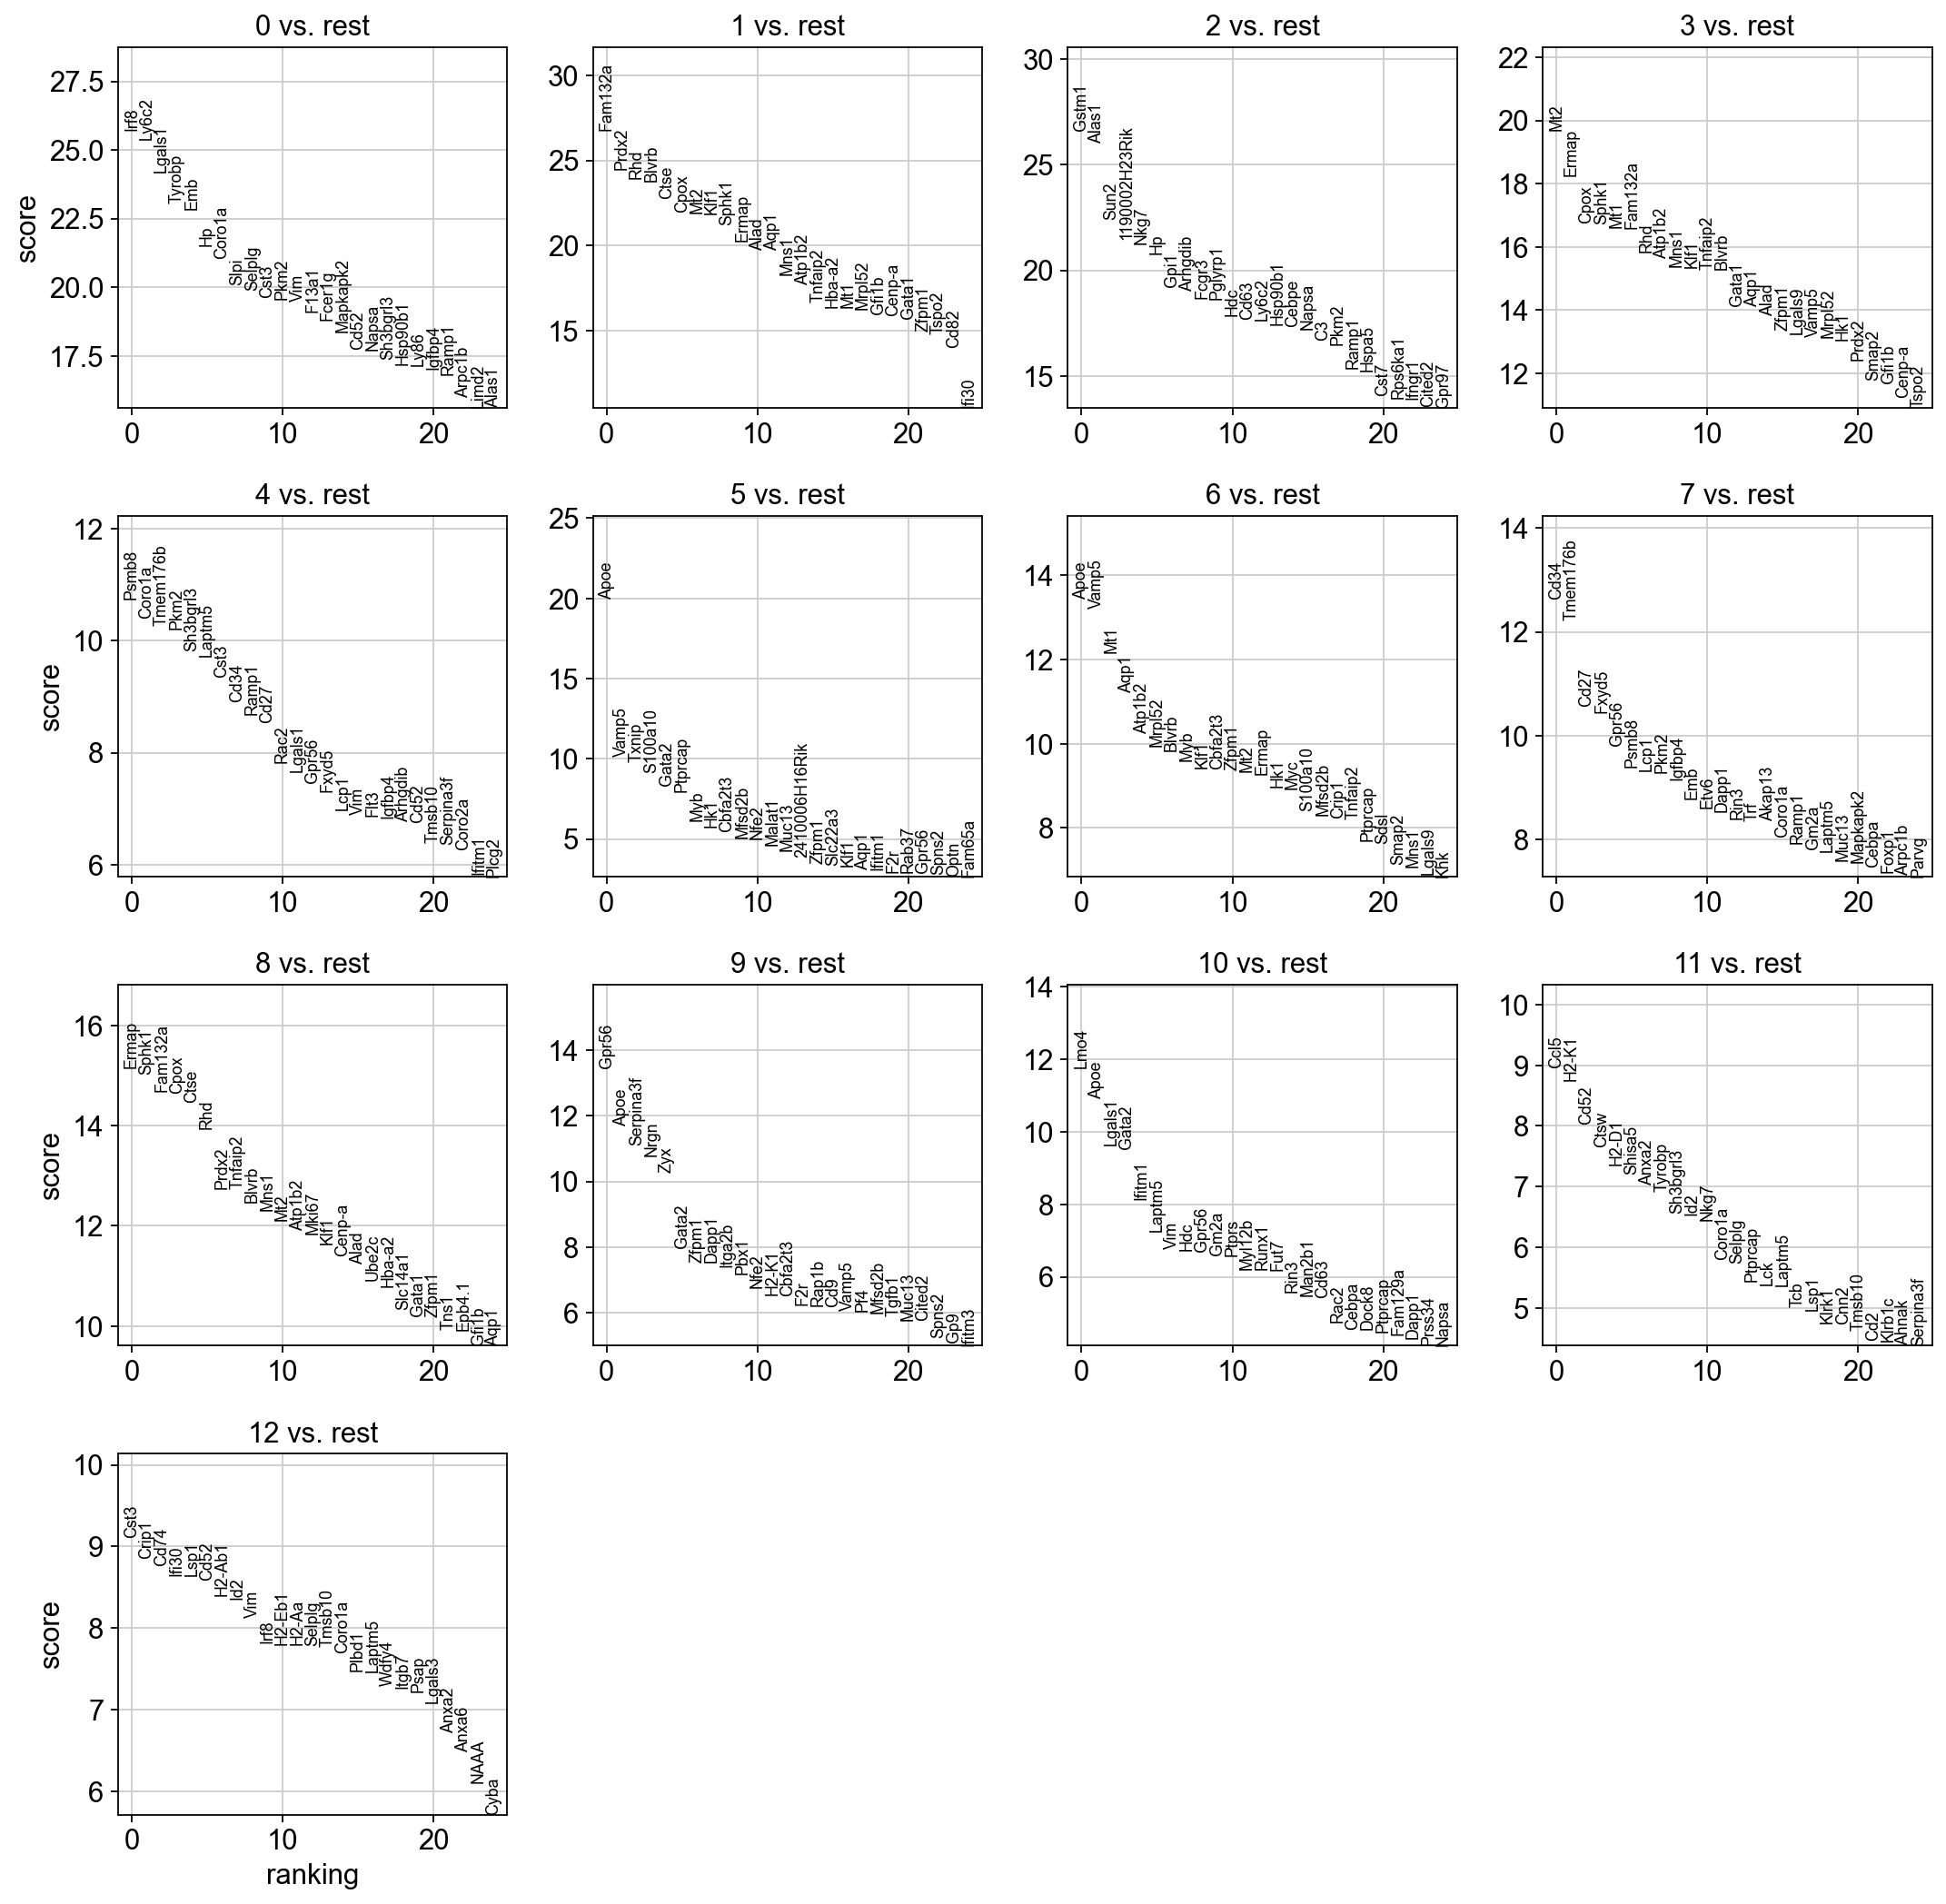

In [46]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

I chose to use the wilcoxon method for my data because it is not sensitive to outliers and since the gene expressions are probably not normally distributed.

Louvain Group Markers Cell Type

In [ ]:
adata.var_names

Index(['0610010K14Rik', '0910001L09Rik', '1110007C09Rik', '1110013L07Rik',
       '1500012F01Rik', '2010002N04Rik', '2210020M01Rik', '2210404O07Rik',
       '2310005E10Rik', '2310014H01Rik',
       ...
       'Zfpm1', 'Zmynd11', 'Zswim4', 'Zyx', 'calp80', 'mFLJ00022', 'mKIAA0569',
       'mKIAA1575', 'rp9', 'slc43a2'],
      dtype='object', length=896)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,Irf8,Fam132a,Elane,Car1,Apoe,H2afy,Atp1b2,Gpr56,Gpr56,Ccl5,Cst3
1,Ly6c2,Mt2,Gstm1,Atp1b2,Car1,Coro1a,Mt2,Dapp1,Nrgn,Cd52,Cd74
2,Emb,Blvrb,Alas1,Mt2,Car2,Laptm5,Slc14a1,Hdc,Serpina3f,Ctsw,Cd52
3,Tyrobp,Klf1,Ctsg,Vamp5,Vamp5,Sh3bgrl3,Jak1,Tmem176b,Zyx,Sh3bgrl3,Crip1
4,Hp,Car2,Sun2,Aqp1,S100a10,Pkm2,Gata1,Lmo4,Apoe,Shisa5,Lsp1


upside cell shows the top marker genes that are calculated with rank_genes_groups. Lists highest expressed 5 genes for each cell cluster .

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p
0,Irf8,7.993161e-150,Fam132a,1.519024e-148,Elane,2.950854e-150,Car1,8.107196e-61,Apoe,6.500052e-100,...,Atp1b2,8.907334e-29,Gpr56,8.388363e-27,Gpr56,1.324685e-31,Ccl5,5.472883e-18,Cst3,1.030553e-18
1,Ly6c2,8.177506e-116,Mt2,2.256979e-116,Gstm1,2.431122e-138,Atp1b2,1.593251e-60,Car1,4.124951e-73,...,Mt2,2.338763e-28,Dapp1,1.278858e-20,Nrgn,2.758193e-27,Cd52,9.889429e-18,Cd74,2.130353e-18
2,Emb,5.216671e-113,Blvrb,6.720469e-107,Alas1,2.048689e-132,Mt2,1.193865e-55,Car2,6.428068e-45,...,Slc14a1,4.959563e-27,Hdc,1.211041e-19,Serpina3f,3.496530e-26,Ctsw,1.277396e-14,Cd52,9.124510e-18
3,Tyrobp,5.025047e-106,Klf1,3.950818e-94,Ctsg,3.189870e-120,Vamp5,2.288948e-52,Vamp5,5.460867e-39,...,Jak1,6.459628e-24,Tmem176b,3.400543e-18,Zyx,1.166446e-22,Sh3bgrl3,1.569142e-13,Crip1,1.060940e-17
4,Hp,1.268491e-101,Car2,3.155294e-84,Sun2,7.231410e-107,Aqp1,1.150143e-48,S100a10,1.881284e-23,...,Gata1,3.276287e-22,Lmo4,1.646248e-17,Apoe,7.316782e-19,Shisa5,8.113981e-13,Lsp1,1.090184e-17


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


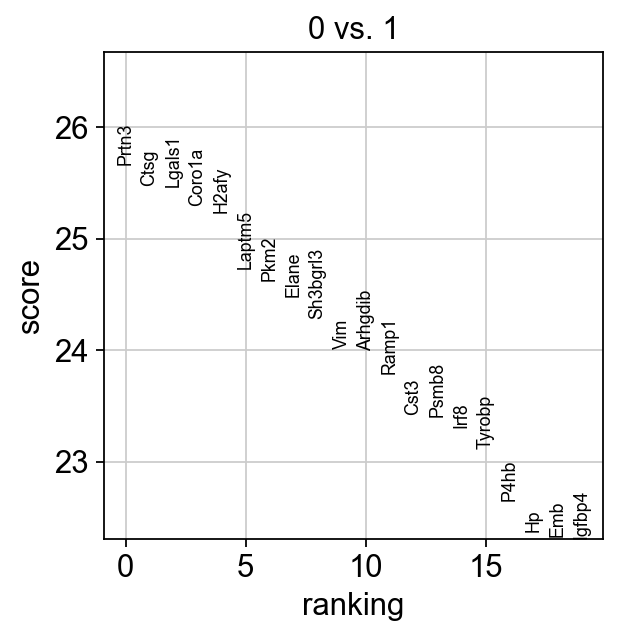

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden', groups=['0'], reference='1', method='wilcoxon') # 20 most expressed genes found with leiden.
sc.pl.rank_genes_groups(adata, groupby='leiden', groups=['0'], n_genes=20) # plots the top 20 highest expressed genes

The genes at the top left are the most characteristic genes that distinguish cluster "0" from cluster "1". They have the highest "score," meaning their expression levels are most different between these two cell groups.

/opt/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


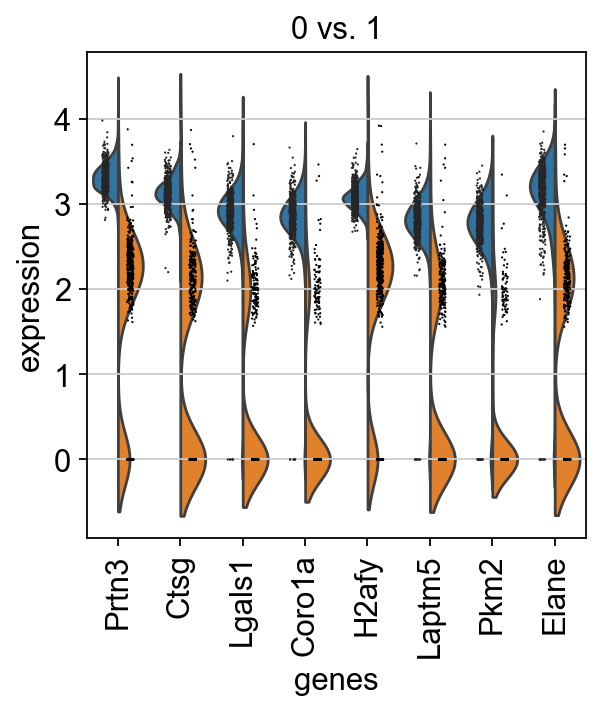

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

upper cell is for a more detailed plotting for a certain group compared to the plot before this. 

In [ ]:
adata = sc.read(results_file)

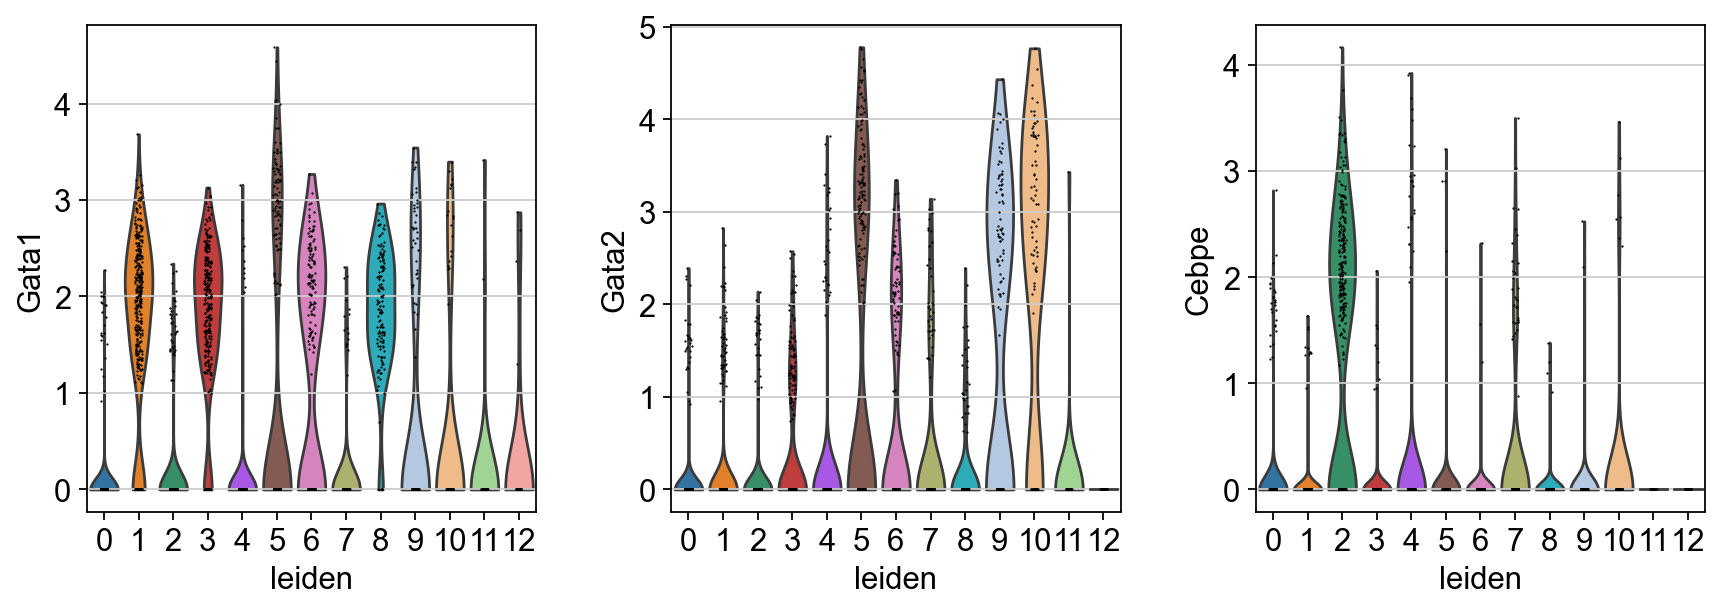

In [80]:
sc.pl.violin(adata, ['Gata1', 'Gata2', 'Cebpe'], groupby='leiden')

x-axis (leiden): Represents the different cell clusters (numbered 0 to 12)
y-axis (expression): Shows the gene expression level.
 Gata1 is highly expressed in specific clusters (around 0 and 7) and very low expression in others. This means that Gata1 might be a marker gene for certain cell types within clusters 0 and 7.
 Gata2 shows varied expression across clusters, with higher levels in some (like 6 and 9) and lower in others. 
 Cebpe appears to be highly expressed in a very specific cluster (around 2) and almost absent in most other clusters. This strongly means Cebpe is a potential marker gene for the cell type(s) within cluster 2.

In [81]:
print(adata.obs['leiden'].nunique() )
adata.obs['leiden'].value_counts() 

13


leiden
0     431
1     387
2     341
3     285
4     282
5     267
6     184
7     152
8     140
9     118
10     86
11     29
12     28
Name: count, dtype: int64

In [84]:
cluster_to_celltype = {
    0: "Monocyte/DC",
    1: "Mature Monocyte",
    2: "Progenitor",
    3: "Macrophage",
    4: "Megakaryocyte",
    5: "Erythroid (late)",
    6: "Erythroid (early)",
    7: "Cytotoxic T/NK",
    8: "IFN-responsive",
    9: "APC (MHC II+)",
    10: "Cycling Progenitor",
    11: "T cell",
    12: "APC"
}
print(len(cluster_to_celltype))

13


when we had the output with 13 plots i examined it and found the data above

In [89]:
marker_genes= ['Irf8', 'Ly6c2', 'Fam132a', 'Gzmb', 'Gstm1', 'Irf7', 'Cst7', 'Cd74', 'Pf4', 'Ccl5', 'Cst3'  ]

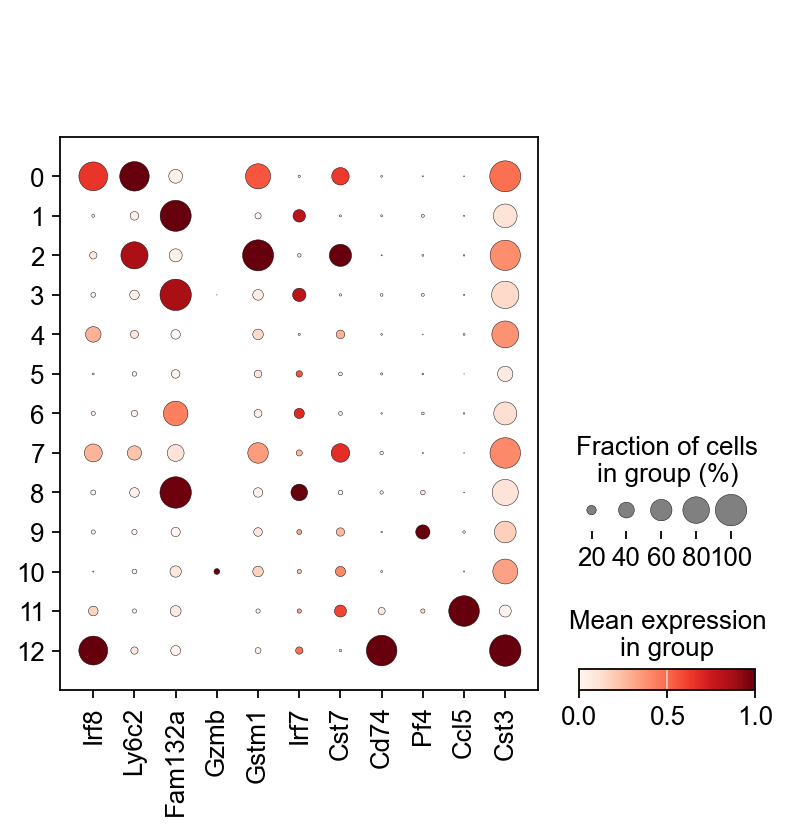

In [90]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden', standard_scale='var')

y-axis shows the cell clusters
size of the dot shows the fraction of cells within that cluster expressing the gene which means larger dot = more cells express it.
The color intensity red indicates the mean expression level of the gene within that cluster darker red means higher average expression.
This plot helps quickly see which genes are expressed in which cell clusters, how many cells in that cluster express the gene, and at what average level


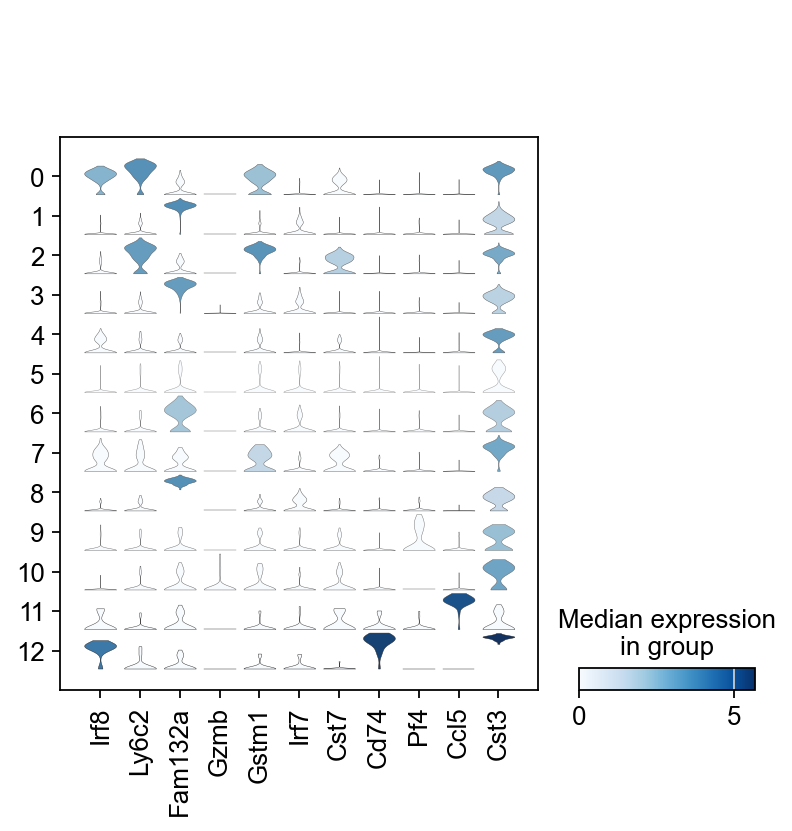

In [91]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden',);


Each violin represents the distribution of expression levels for a specific gene in a specific cell cluster.
Intensity of the blue color indicates the median expression level of the gene in that cluster darker blue means higher median expression.
